In [ ]:
#Master simulation to assess the performance of a HEDGEFUNDIE style portfolio. Goals are as follow...

#1. I'm improving simulated returns of leveraged instruments by using a model (currently linear) to predict their deviance from a 2x, 3x, etc. leverage.
#2. I'm then going to do a quick tree-search algorithm (might beef this up later to a monte carlo tree search/counterfactual regret algorithm) to search the optimal allocation of a portfolio of SPY, QQQ, long-term treasury bonds leveraged -3...+3x. 
#3. I'm then going to split up my ~23 years of data into different markets (bull, flat, recession) and have a tuneable sim where you can set the relative frequency of each event. So it'll simulate, e.g., many more 2008-style recessions using the actual 2008 data plus a noise term.
#So I can get a bit more granularity than just Hedgefundie and variants and also provide a backtester for different market conditions.

#Sections are as follows

#0. Setup, imports

#1. Income considerations, total compensation growth

#2. Data pulling and normalization - we consider all variants of -3...+3 leveraged (including 1x) 30 year treasury bonds, QQQ, SPY. We correct by the performance drop of TQQQ, QLD, UPRO, SSO relative to their indices.

#3. Simulation results - we use Monte Carlo tree search to select an optimal strategy. This is the suggested portfolio assuming current trends hold.

#4. Advanced sim - we use data from Dot Com, 2008, COVID recessions to simulate portfolio over ~40 years with different "crash" rates based on data from these three recessions. 
# Custom strategies can be input at this stage.

# In (3.) sim we had three crashes in 23 years - can be tuned up or down for the next 25 year simulated period
# In total the US has experienced 12 recessions in the "modern" post WW2 era 1945-2022 - a mean of one recession every 6.4 years (counting 1980 and 1981 recession as one recession, otherwise mean of 5.8)
# The modern patten (1990 - 2022) has seen fewer recessions of higher severity - 4 in 32 years - a mean of one recession every 8 years
# Note of our three recessions they display very different patterns. 
# 2000 was characterized by an extreme drop in the highest value companies but the lower value were relatively unaffected. Worst for a HEDGEFUNDIE portfolio.
# 2008 was broad and sustained. Very bad for a HEDGEFUNDIE portfolio.
# 2021 affected some sectors more heavily and DID NOT affect large companies as much. On the merits pretty neutral for a HEDGEFUNDIE portfolio if you hold.

In [ ]:
!pip install yfinance

     |████████████████████████████████| 63 kB 691 kB/s 
     |████████████████████████████████| 6.4 MB 20.1 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
#section 0 - imports
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like

import pandas_datareader.data as web
import datetime

import yfinance as yf
import numpy as np

import sklearn

from sklearn.linear_model import LinearRegression
import itertools
import matplotlib.pyplot as plt
import numba
from numba import jit
#you will need to restart the runtime

In [ ]:
#section 1 - initial params

#45 "income earning" years, care about wealth at age 75 => 50 total years
total_years = 50
retirement_age = 70
starting_age = 25

#assume faang tech salary, hard work - capping at 1m tc growing 7.5% annually until then (on average)
tc = 250000
tc_percent_growth = 1.075

In [ ]:
#pull the last ~23 years of SPY - 1999 jul 1 - current date
def get_spy():

  spydat = yf.download('SPY', start = "1999-06-01", end = "2000-06-01")

  for i in range(2000, 2022):

    spycurr = yf.download('SPY', start = str(i)+"-06-01", end = str(i+1)+"-06-01")

    spydat = pd.concat([spydat, spycurr])
  
  return spydat[:-1]

#pull the last ~26 years of QQQ - 1996 jul 1 - current date
def get_qqq():

  qqqdat = yf.download('QQQ', start = "1999-06-01", end = "2000-06-01")

  for i in range(2000, 2022):

    qqqcurr = yf.download('QQQ', start = str(i)+"-06-01", end = str(i+1)+"-06-01")

    qqqdat = pd.concat([qqqdat, qqqcurr])
  
  return qqqdat[:-1]

#pull the last ~26 years of 30yr bonds - 1996 jul 1 - current date
def get_bond():

  bonddat = yf.download('VUSTX', start = "1999-06-01", end = "2000-06-01")

  for i in range(2000, 2022):

    bondcurr = yf.download('VUSTX', start = str(i)+"-06-01", end = str(i+1)+"-06-01")

    bonddat = pd.concat([bonddat, bondcurr])
  
  return bonddat[:-1]

#pull the last ~6 years of TQQQ - 2010-01-01 - 2022-01-01
def get_tqqq():

  tqqqdat = yf.download('TQQQ', start = "2016-01-01", end = "2017-01-01")

  for i in range(2017, 2022):

    tqqqcurr = yf.download('TQQQ', start = str(i)+"-01-01", end = str(i+1)+"-01-01")

    tqqqdat = pd.concat([tqqqdat, tqqqcurr])
  
  return tqqqdat

#pull the last ~6 years of QLD - 2010-01-01 - 2022-01-01
def get_qld():

  stonkdat = yf.download('QLD', start = "2016-01-01", end = "2017-01-01")

  for i in range(2017, 2022):

    stonkcurr = yf.download('QLD', start = str(i)+"-01-01", end = str(i+1)+"-01-01")

    stonkdat = pd.concat([stonkdat, stonkcurr])
  
  return stonkdat

#pull the last ~6 years of UPRO - 2010-01-01 - 2022-01-01
def get_upro():

  stonkdat = yf.download('UPRO', start = "2016-01-01", end = "2017-01-01")

  for i in range(2017, 2022):

    stonkcurr = yf.download('UPRO', start = str(i)+"-01-01", end = str(i+1)+"-01-01")

    stonkdat = pd.concat([stonkdat, stonkcurr])
  
  return stonkdat

#pull the last ~6 years of SSO - 2010-01-01 - 2022-01-01
def get_sso():

  stonkdat = yf.download('SSO', start = "2016-01-01", end = "2017-01-01")

  for i in range(2017, 2022):

    stonkcurr = yf.download('SSO', start = str(i)+"-01-01", end = str(i+1)+"-01-01")

    stonkdat = pd.concat([stonkdat, stonkcurr])
  
  return stonkdat

#pull the last ~6 years of TMF - 2010-01-01 - 2022-01-01
def get_tmf():

  stonkdat = yf.download('TMF', start = "2016-01-01", end = "2017-01-01")

  for i in range(2017, 2022):

    stonkcurr = yf.download('TMF', start = str(i)+"-01-01", end = str(i+1)+"-01-01")

    stonkdat = pd.concat([stonkdat, stonkcurr])
  
  return stonkdat


In [ ]:
#NOW WE GET THE ACTUAL DATA
spydat = get_spy()
qqqdat = get_qqq()
bonddat = get_bond()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
tqqqdat = get_tqqq()
qlddat = get_qld()
uprodat = get_upro()
ssodat = get_sso()
tmfdat = get_tmf()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
qqqdat.shape, spydat.shape, bonddat.shape, tqqqdat.shape, qlddat.shape, uprodat.shape, ssodat.shape, tmfdat.shape

((5708, 6),
 (5708, 6),
 (5720, 6),
 (1511, 6),
 (1511, 6),
 (1511, 6),
 (1511, 6),
 (1511, 6))

In [ ]:
#Data is missing trading days. There are also some duplicate days. We linearly interpolate missing values.
def correct_missing_bonds(bonddat, spydat, qqqdat):

  bonddat = bonddat[~bonddat.index.duplicated(keep='first')]
  spydat = spydat[~spydat.index.duplicated(keep='first')]
  qqqdat = qqqdat[~qqqdat.index.duplicated(keep='first')]

  mux = bonddat.index.union(bonddat.index)
  bonddat = bonddat.reindex(mux)
  bonddat = bonddat.interpolate()

  mux = spydat.index.union(bonddat.index)
  spydat = spydat.reindex(mux)
  spydat = spydat.interpolate()

  mux = spydat.index.union(bonddat.index)
  qqqdat = qqqdat.reindex(mux)
  qqqdat = qqqdat.interpolate()

  mux = bonddat.index.union(spydat.index)
  bonddat = bonddat.reindex(mux)
  bonddat = bonddat.interpolate()

  bonddat = bonddat[~bonddat.index.duplicated(keep='first')]
  spydat = spydat[~spydat.index.duplicated(keep='first')]
  qqqdat = qqqdat[~qqqdat.index.duplicated(keep='first')]


  return bonddat, spydat, qqqdat


In [ ]:
bonddat, spydat, qqqdat = correct_missing_bonds(bonddat, spydat, qqqdat)

In [ ]:
qqqdat.shape, spydat.shape, bonddat.shape, tqqqdat.shape, qlddat.shape, uprodat.shape, ssodat.shape, tmfdat.shape

((5708, 6),
 (5708, 6),
 (5708, 6),
 (1511, 6),
 (1511, 6),
 (1511, 6),
 (1511, 6),
 (1511, 6))

In [ ]:
#adds a 1x percent return column to qqq, spy, bond dataframes as well as to their leveraged counterparts

def get_percent_returns(spydat, qqqdat, bonddat, tqqqdat, qlddat, uprodat, ssodat, tmfdat):

  qqqdat['PERCENT_1X'] = 0

  spydat['PERCENT_1X'] = 0

  bonddat['PERCENT_1X'] = 0

  tqqqdat['PERCENT_1X'] = 0

  qlddat['PERCENT_1X'] = 0

  uprodat['PERCENT_1X'] = 0

  ssodat['PERCENT_1X'] = 0

  tmfdat['PERCENT_1X'] = 0

  for i in range(1, len(qqqdat)):

    qqqdat['PERCENT_1X'].iloc[i] = (qqqdat['Close'].iloc[i] - qqqdat['Close'].iloc[i-1])/qqqdat['Close'].iloc[i-1]

    spydat['PERCENT_1X'].iloc[i] = (spydat['Close'].iloc[i] - spydat['Close'].iloc[i-1])/spydat['Close'].iloc[i-1]

    bonddat['PERCENT_1X'].iloc[i] = (bonddat['Close'].iloc[i] - bonddat['Close'].iloc[i-1])/bonddat['Close'].iloc[i-1]
  
  for i in range(1, len(tqqqdat)):

    tqqqdat['PERCENT_1X'].iloc[i] = (tqqqdat['Adj Close'].iloc[i] - tqqqdat['Adj Close'].iloc[i-1])/tqqqdat['Adj Close'].iloc[i-1]

    qlddat['PERCENT_1X'].iloc[i] = (qlddat['Adj Close'].iloc[i] - qlddat['Adj Close'].iloc[i-1])/qlddat['Adj Close'].iloc[i-1]

    uprodat['PERCENT_1X'].iloc[i] = (uprodat['Adj Close'].iloc[i] - uprodat['Adj Close'].iloc[i-1])/uprodat['Adj Close'].iloc[i-1]

    ssodat['PERCENT_1X'].iloc[i] = (ssodat['Adj Close'].iloc[i] - ssodat['Adj Close'].iloc[i-1])/ssodat['Adj Close'].iloc[i-1]

    tmfdat['PERCENT_1X'].iloc[i] = (tmfdat['Adj Close'].iloc[i] - tmfdat['Adj Close'].iloc[i-1])/tmfdat['Adj Close'].iloc[i-1]

  return spydat, qqqdat, bonddat, tqqqdat, qlddat, uprodat, ssodat, tmfdat

In [ ]:
spydat, qqqdat, bonddat, tqqqdat, qlddat, uprodat, ssodat, tmfdat = get_percent_returns(spydat, qqqdat, bonddat, tqqqdat, qlddat, uprodat, ssodat, tmfdat)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
#returns assuming dividends are reinvested
def get_dividended_returns(spydat, qqqdat, bonddat):
    qqqdat['PERCENT_DIV'] = 0

    spydat['PERCENT_DIV'] = 0

    bonddat['PERCENT_DIV'] = 0

    for i in range(1, len(qqqdat)):
      qqqdat['PERCENT_DIV'].iloc[i] = (qqqdat['Adj Close'].iloc[i] - qqqdat['Adj Close'].iloc[i-1])/qqqdat['Adj Close'].iloc[i-1]
      spydat['PERCENT_DIV'].iloc[i] = (spydat['Adj Close'].iloc[i] - spydat['Adj Close'].iloc[i-1])/spydat['Adj Close'].iloc[i-1]
      bonddat['PERCENT_DIV'].iloc[i] = (bonddat['Adj Close'].iloc[i] - bonddat['Adj Close'].iloc[i-1])/bonddat['Adj Close'].iloc[i-1]

    return spydat, qqqdat, bonddat

In [ ]:
spydat, qqqdat, bonddat = get_dividended_returns(spydat, qqqdat, bonddat)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
spydat.shape, qqqdat.shape, bonddat.shape, tqqqdat.shape, qlddat.shape, uprodat.shape, ssodat.shape, tmfdat.shape

((5708, 8),
 (5708, 8),
 (5708, 8),
 (1511, 7),
 (1511, 7),
 (1511, 7),
 (1511, 7),
 (1511, 7))

In [ ]:
#uses the returns of the un-leveraged versions to predict the 2x, 3x leveraged counterpart
def estimate_real_levered_returns(spydat, qqqdat, tqqqdat, qlddat, uprodat, ssodat, bonddat, tmfdat):
  sub_qqq = qqqdat.loc[qqqdat.index.intersection(tqqqdat.index)]
  sub_spy = spydat.loc[spydat.index.intersection(uprodat.index)]
  sub_bond = bonddat.loc[bonddat.index.intersection(tmfdat.index)]
  
  qqq_2x_diff = qlddat['PERCENT_1X'].values
  qqq_3x_diff = tqqqdat['PERCENT_1X'].values
  spy_2x_diff = ssodat['PERCENT_1X'].values
  spy_3x_diff = uprodat['PERCENT_1X'].values
  bond_3x_diff = tmfdat['PERCENT_1X'].values

  qqq_2xreg = LinearRegression().fit(sub_qqq['PERCENT_1X'].values.reshape(-1, 1), qqq_2x_diff.reshape(-1, 1))
  qqq_3xreg = LinearRegression().fit(sub_qqq['PERCENT_1X'].values.reshape(-1, 1), qqq_3x_diff.reshape(-1, 1))

  spy_2xreg = LinearRegression().fit(sub_spy['PERCENT_1X'].values.reshape(-1, 1), spy_2x_diff.reshape(-1, 1))
  spy_3xreg = LinearRegression().fit(sub_spy['PERCENT_1X'].values.reshape(-1, 1), spy_3x_diff.reshape(-1, 1))

  bond_3xreg = LinearRegression().fit(sub_bond['PERCENT_DIV'].values.reshape(-1, 1), bond_3x_diff.reshape(-1, 1))

  print(qqq_2xreg.score(sub_qqq['PERCENT_1X'].values.reshape(-1, 1), qqq_2x_diff.reshape(-1, 1)))
  print(qqq_3xreg.score(sub_qqq['PERCENT_1X'].values.reshape(-1, 1), qqq_3x_diff.reshape(-1, 1)))

  print(spy_2xreg.score(sub_spy['PERCENT_1X'].values.reshape(-1, 1), spy_2x_diff.reshape(-1, 1)))
  print(spy_3xreg.score(sub_spy['PERCENT_1X'].values.reshape(-1, 1), spy_3x_diff.reshape(-1, 1)))

  print(bond_3xreg.score(sub_bond['PERCENT_1X'].values.reshape(-1, 1), bond_3x_diff.reshape(-1, 1)))

  return qqq_2xreg, qqq_3xreg, spy_2xreg, spy_3xreg, bond_3xreg

In [ ]:
qqq_2xreg, qqq_3xreg, spy_2xreg, spy_3xreg, bond_3xreg = estimate_real_levered_returns(spydat, qqqdat, tqqqdat, qlddat, uprodat, ssodat, bonddat, tmfdat)

0.9960178941044445
0.9950671633783188
0.994796066205225
0.9945560377029101
0.9036495539844479


In [ ]:
qqq_2xreg.coef_, qqq_3xreg.coef_, spy_2xreg.coef_, spy_3xreg.coef_, bond_3xreg.coef_

(array([[1.99091187]]),
 array([[2.93593702]]),
 array([[2.0050411]]),
 array([[3.00539184]]),
 array([[3.12407282]]))

In [ ]:
qqq_2xreg.intercept_, qqq_3xreg.intercept_, spy_2xreg.intercept_, bond_3xreg.intercept_

(array([5.3262281e-06]),
 array([1.16233262e-05]),
 array([6.62156277e-05]),
 array([-0.00014428]))

In [ ]:
#adds a percent return column to qqq, spy dataframes as well as a 2x, 3x, -1x, -2x, -3x return column
#we use previous close divided by current close to include the effects of premarket trading
#NiX refers to the inverse leveraged etfs, 1x refers to normal etf
def get_levered_returns(spydat, qqqdat, bonddat, qqq_2xreg, qqq_3xreg, spy_2xreg, spy_3xreg, bond_3xreg):

  qqqdat['PERCENT_2X'] = 0
  qqqdat['PERCENT_3X'] = 0
  qqqdat['PERCENT_N1X'] = 0
  qqqdat['PERCENT_N2X'] = 0
  qqqdat['PERCENT_N3X'] = 0

  spydat['PERCENT_2X'] = 0
  spydat['PERCENT_3X'] = 0
  spydat['PERCENT_N1X'] = 0
  spydat['PERCENT_N2X'] = 0
  spydat['PERCENT_N3X'] = 0

  bonddat['PERCENT_3X'] = 0
  bonddat['PERCENT_N3X'] = 0

  for i in range(1, len(qqqdat)):

    qqqdat['PERCENT_2X'].iloc[i] = qqq_2xreg.predict(qqqdat['PERCENT_1X'].iloc[i].reshape(-1, 1))#qqqdat['PERCENT_1X'].iloc[i]*2 #+ 
    qqqdat['PERCENT_3X'].iloc[i] = qqq_3xreg.predict(qqqdat['PERCENT_1X'].iloc[i].reshape(-1, 1))#qqqdat['PERCENT_1X'].iloc[i]*3 #+ 
    qqqdat['PERCENT_N1X'].iloc[i] = qqqdat['PERCENT_1X'].iloc[i]*(-1)
    qqqdat['PERCENT_N2X'].iloc[i] = qqqdat['PERCENT_2X'].iloc[i]*(-1)
    qqqdat['PERCENT_N3X'].iloc[i] = qqqdat['PERCENT_3X'].iloc[i]*(-1)

    spydat['PERCENT_2X'].iloc[i] = spy_2xreg.predict(spydat['PERCENT_1X'].iloc[i].reshape(-1, 1))#spydat['PERCENT_1X'].iloc[i]*2 #+ 
    spydat['PERCENT_3X'].iloc[i] = spy_3xreg.predict(spydat['PERCENT_1X'].iloc[i].reshape(-1, 1))#spydat['PERCENT_1X'].iloc[i]*3 #+ 
    spydat['PERCENT_N1X'].iloc[i] = spydat['PERCENT_1X'].iloc[i]*(-1)
    spydat['PERCENT_N2X'].iloc[i] = spydat['PERCENT_2X'].iloc[i]*(-1)
    spydat['PERCENT_N3X'].iloc[i] = spydat['PERCENT_3X'].iloc[i]*(-1)

    bonddat['PERCENT_3X'].iloc[i] = bond_3xreg.predict(bonddat['PERCENT_DIV'].iloc[i].reshape(-1, 1))
    bonddat['PERCENT_N3X'].iloc[i] = bonddat['PERCENT_3X'].iloc[i]*(-1)

  return spydat, qqqdat, bonddat

In [ ]:
spydat, qqqdat, bonddat = get_levered_returns(spydat, qqqdat, bonddat, qqq_2xreg, qqq_3xreg, spy_2xreg, spy_3xreg, bond_3xreg)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

3.8111185346579455 3.8531170811691355


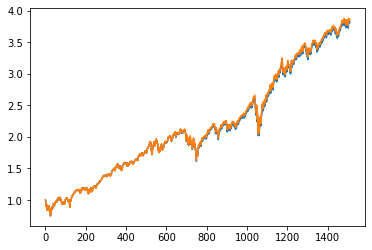

In [ ]:
#2x qqq test
mux = qlddat.index.union(qqqdat.index)

dummy = qqqdat.loc[qlddat.index]

x1 = np.zeros(len(qlddat['PERCENT_1X']))
x2 = np.zeros(len(qlddat['PERCENT_1X']))
x1[0] = 1
x2[0] = 1
for i in range(1, len(x1)):
  x1[i] = x1[i-1]*1+qlddat['PERCENT_1X'].iloc[i]
  x2[i] = x2[i-1]*1+dummy['PERCENT_2X'].iloc[i]
plt.plot(x1)
plt.plot(x2)
print(x1[-1], x2[-1])

5.15116558752084 5.213095794438104


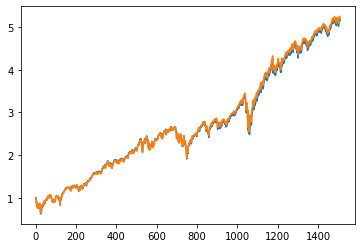

In [ ]:
#3x qqq test
mux = tqqqdat.index.union(qqqdat.index)

dummy = qqqdat.loc[qlddat.index]

x1 = np.zeros(len(tqqqdat['PERCENT_1X']))
x2 = np.zeros(len(tqqqdat['PERCENT_1X']))
x1[0] = 1
x2[0] = 1
for i in range(1, len(x1)):
  x1[i] = x1[i-1]*1+tqqqdat['PERCENT_1X'].iloc[i]
  x2[i] = x2[i-1]*1+dummy['PERCENT_3X'].iloc[i]
plt.plot(x1)
plt.plot(x2)
print(x1[-1], x2[-1])

2.994309667229927 3.0222728277012796


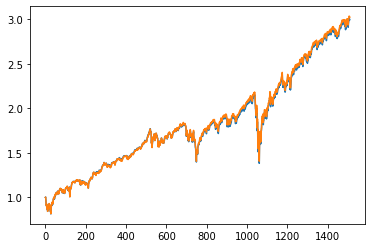

In [ ]:
#2x spy test

dummy = spydat.loc[ssodat.index]

x1 = np.zeros(len(ssodat['PERCENT_1X']))
x2 = np.zeros(len(ssodat['PERCENT_1X']))
x1[0] = 1
x2[0] = 1
for i in range(1, len(x1)):
  x1[i] = x1[i-1]*1+ssodat['PERCENT_1X'].iloc[i]
  x2[i] = x2[i-1]*1+dummy['PERCENT_2X'].iloc[i]
plt.plot(x1)
plt.plot(x2)
print(x1[-1], x2[-1])

3.968422563572101 4.010350864332976


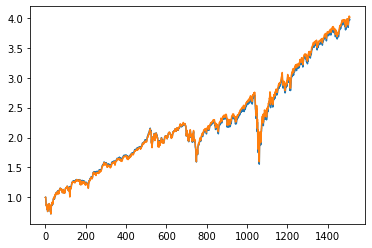

In [ ]:
#3x spy test

dummy = spydat.loc[uprodat.index]

x1 = np.zeros(len(uprodat['PERCENT_1X']))
x2 = np.zeros(len(uprodat['PERCENT_1X']))
x1[0] = 1
x2[0] = 1
for i in range(1, len(x1)):
  x1[i] = x1[i-1]*1+uprodat['PERCENT_1X'].iloc[i]
  x2[i] = x2[i-1]*1+dummy['PERCENT_3X'].iloc[i]
plt.plot(x1)
plt.plot(x2)
print(x1[-1], x2[-1])

1511 1511
1.9582614239997713 1.937902697612403


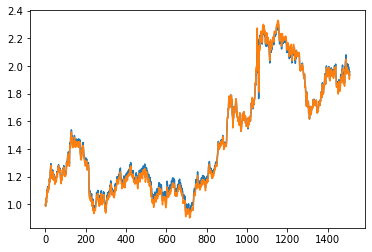

In [ ]:
#3x bond test

dummy = bonddat.loc[tmfdat.index]

print(len(dummy), len(tmfdat))

x1 = np.zeros(len(tmfdat['PERCENT_1X']))
x2 = np.zeros(len(tmfdat['PERCENT_1X']))
x1[0] = 1
x2[0] = 1
for i in range(1, len(x1)):
  x1[i] = x1[i-1]*1+tmfdat['PERCENT_1X'].iloc[i]
  x2[i] = x2[i-1]*1+dummy['PERCENT_3X'].iloc[i]
plt.plot(x1)
plt.plot(x2)
print(x1[-1], x2[-1])

In [ ]:
#we now have 18 assets - spy (levered -3...3x), qqq (levered -3...3x), 30yr bonds (levered -3, 1, 3x)
#the covered timespan includes three major recessions (dotcom, 2008, covid) and a variety of market conditions
#we bucket these assets into (at the moment) 10% allocations
#so beginning with 1x spy, you can have 0, 20, 40, 80, 100 allocated
#we update using MCTS and calculating sortino ratio relative to SPY

In [ ]:
#initial method of game tree... can change later
#select a "bundle" of 1...5 assets to use
#then in stage 2, select allocation

In [ ]:
#basic balls and boxes solver that yields possible sums of "pie" amounts to distribute to assets
def partitions(n, b):
    masks = np.identity(b, dtype=int)
    for c in itertools.combinations_with_replacement(masks, n): 
        yield sum(c)

#handler to make all combinations of a fixed number of pie slices between n players (boxes and balls problem)
def makepossiblepieslices(numbuckets, numdivisions):
    boxes = numbuckets
    balls = numdivisions
        
    iterset = np.array(list(partitions(balls, boxes))) #generate all pie distributions
    
    #normalize the pie distributions appropriately
    finallist = []
    for j in range(len(iterset)):
        arr = np.array(iterset[j])
        arr = arr/(balls)
        finallist.append((np.array(iterset[j]))/numdivisions)
            
    finallist = np.array(finallist)
        
    return finallist

In [ ]:
pies = makepossiblepieslices(15, 5)

In [ ]:
len(pies)

11628

In [ ]:
#quick calculator for how to rebalance portfolio given our desired allocation
@jit(nopython=True)
def rebalance(shmoney, alloc):
  cash = 0

  for i in range(len(shmoney)):
    cash+=shmoney[i]

  for i in range(len(alloc)):
    shmoney[i] = (cash*alloc[i])

  return shmoney

In [ ]:
#quick calculator to update asset values every day
@jit(nopython=True)
def update_assets(shmoney, spydat, qqqdat, bonddat, index):

  for i in range(6):

      shmoney[i]*= 1+qqqdat[index, -6+i]
      shmoney[i+6]*= 1+spydat[index, -6+i]
      if(i < 3):
        shmoney[i+12]*= 1+bonddat[index, -3+i]

  return shmoney

In [ ]:
#title. taxfree portfolio simulator for a strategy (piediv) and our data. Assume no taxes, no added principal.
@jit(nopython=True)
def run_portfolio_taxfree_nodca(piediv, rebalancefreq, spydat, qqqdat, bonddat):

  #paydays assuming you add a % of initial principal each payday
  #paydays = [30, 58, 89, 119, 150, 180, 211, 242, 272, 303, 333, 364]

  #initialization stuff...
  starting_principal = 1
  month_contrib = starting_principal/10

  running_value = np.zeros((len(spydat)+1, 18))
  running_sum = np.zeros((len(spydat)+1))
  running_sum[0] = starting_principal
  for i in range(len(piediv)):
    running_value[0, i] = starting_principal*piediv[i]
  #update
  for i in range(len(spydat)):
    running_value[i+1,:] = update_assets(running_value[i,:], spydat, qqqdat, bonddat, i)
    running_sum[i+1] = np.sum(running_value[i+1,:])
  
    if(i%rebalancefreq == 0 and i > 0):
      running_value[i+1] = rebalance(running_value[i+1], piediv)
  
  return running_value, running_sum

In [ ]:
def printpie(pieval):
  things = ['1xqqq', '2xqqq', '3xqqq', '-1xqqq', '-2xqqq', '-3xqqq', '1xspy', '2xspy', '3xspy', '-1xspy', '-2xspy', '-3xspy', '1xbond', '3xbond', '-3xbond']

  for i in range(len(pieval)):
    if(pieval[i] > 0):
      print(pieval[i], things[i])

In [ ]:
#get return of just bonds
def get_risk_free(spydat, qqqdat, bonddat):
  allbond = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
  vals, sums = run_portfolio_taxfree_nodca(allbond, 10000000000, spydat.to_numpy(), qqqdat.to_numpy(), bonddat.to_numpy())
  return sums[-1]

In [ ]:
risk_free_return = get_risk_free(spydat, qqqdat, bonddat)

<ipython-input-35-f86e2e77066a>:23: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'alloc' of function 'rebalance'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-33-2be6259d24d1>", line 3:
@jit(nopython=True)
def rebalance(shmoney, alloc):
^

  running_value[i+1] = rebalance(running_value[i+1], piediv)
/usr/local/lib/python3.7/dist-packages/numba/core/ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'piediv' of function 'run_portfolio_taxfree_nodca'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-35-f86e2e77066a>", line 3:
@jit(nopython=True)
def run_

In [ ]:
#get return of just bonds
allbond = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
vals, sums = run_portfolio_taxfree_nodca(allbond, 10000000000, spydat.to_numpy(), qqqdat.to_numpy(), bonddat.to_numpy())
sums[-1]

13.647217937850058

In [ ]:
risk_free_return

4.18217432883846

In [ ]:
#calculate cagr
def calc_cagr(ending, starting, years):
  return 100*((ending/starting)**(1/years)-1)

In [ ]:
#get sortino of a strategy
def calc_sortino(running_sum, risk_free_return):
  perdiff = (np.diff(running_sum) / running_sum[1:])*100

  return (calc_cagr(running_sum[-1], 1, 23.7) - calc_cagr(risk_free_return, 1, 23.7))/np.std(perdiff[perdiff < 0])

In [ ]:
allbond = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
vals, sums = run_portfolio_taxfree_nodca(allbond, 10000000000, spydat.to_numpy(), qqqdat.to_numpy(), bonddat.to_numpy())
sums[-1], calc_sortino(sums, risk_free_return)

(8.361958796611288, 2.2480992876293)

In [ ]:
allbond = [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
vals, sums = run_portfolio_taxfree_nodca(allbond, 10000000000, spydat.to_numpy(), qqqdat.to_numpy(), bonddat.to_numpy())
sums[-1], calc_sortino(sums, risk_free_return)

(5.336918119235605, 1.071616038836089)

In [ ]:
allbond = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
vals, sums = run_portfolio_taxfree_nodca(allbond, 10000000000, spydat.to_numpy(), qqqdat.to_numpy(), bonddat.to_numpy())
sums[-1], calc_sortino(sums, risk_free_return)

(4.18217432883846, 0.0)

In [ ]:
#SECTION 1 - TAX FREE, NO ADDITIONAL PRINCIPAL ACCOUNT

In [ ]:
#tax free, no additional principal, no rebalancing
max_sortino = 0
max_ind = -1
max_profit = 0
max_pind = -1
for i in range(len(pies)):
  running_value, running_sum = run_portfolio_taxfree_nodca(pies[i], 10000000000, spydat.to_numpy(), qqqdat.to_numpy(), bonddat.to_numpy())
  sortino = calc_sortino(running_sum, risk_free_return)
  if(sortino > max_sortino):
    max_sortino = sortino
    max_ind = i
  if(running_sum[-1] > max_profit):
    max_profit = running_sum[-1]
    max_pind = i
print(max_sortino)
printpie(pies[max_ind])
print(max_profit)
printpie(pies[max_pind])

3.410581770331679
0.8 1xqqq
0.2 3xbond
13.647217937850058
1.0 3xbond


In [ ]:
running_value_portfolio_taxfree_nodca_norebal, running_sum_portfolio_taxfree_nodca_norebal = run_portfolio_taxfree_nodca(pies[max_ind], 10000000000, spydat.to_numpy(), qqqdat.to_numpy(), bonddat.to_numpy())
value_taxf_ndca_nreb, sum_taxf_ndca_nreb = run_portfolio_taxfree_nodca(pies[max_pind], 10000000000, spydat.to_numpy(), qqqdat.to_numpy(), bonddat.to_numpy())


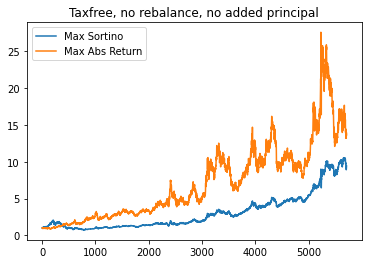

In [ ]:
plt.title("Taxfree, no rebalance, no added principal")
plt.plot(running_sum_portfolio_taxfree_nodca_norebal)
plt.plot(sum_taxf_ndca_nreb)
plt.legend(["Max Sortino", "Max Abs Return"])
#plt.yscale("log")

In [ ]:
#tax free, no additional principal, 120d rebalancing
max_sortino = 0
max_ind = -1
max_profit = 0
max_pind = -1
for i in range(len(pies)):
  running_value, running_sum = run_portfolio_taxfree_nodca(pies[i], 120, spydat.to_numpy(), qqqdat.to_numpy(), bonddat.to_numpy())
  sortino = calc_sortino(running_sum, risk_free_return)
  if(sortino > max_sortino):
    max_sortino = sortino
    max_ind = i
  if(running_sum[-1] > max_profit):
    max_profit = running_sum[-1]
    max_pind = i
print(max_sortino)
printpie(pies[max_ind])
print(max_profit)
printpie(pies[max_pind])

9.651784304534312
0.2 3xqqq
0.2 3xspy
0.6 3xbond
92.72715566138932
0.6 3xqqq
0.4 3xbond


In [ ]:
running_value_portfolio_taxfree_nodca_120drebal, running_sum_portfolio_taxfree_nodca_120drebal = run_portfolio_taxfree_nodca(pies[max_ind], 120, spydat.to_numpy(), qqqdat.to_numpy(), bonddat.to_numpy())
value_taxf_ndca_120d, sum_taxf_ndca_120d = run_portfolio_taxfree_nodca(pies[max_pind], 120, spydat.to_numpy(), qqqdat.to_numpy(), bonddat.to_numpy())


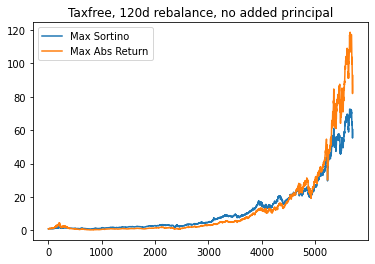

In [ ]:
plt.title("Taxfree, 120d rebalance, no added principal")

plt.plot(running_sum_portfolio_taxfree_nodca_120drebal)
plt.plot(sum_taxf_ndca_120d)
plt.legend(["Max Sortino", "Max Abs Return"])

#plt.yscale("log")

In [ ]:
#tax free, no additional principal, 120d rebalancing
max_sortino = 0
max_ind = -1
max_profit = 0
max_pind = -1
for i in range(len(pies)):
  running_value, running_sum = run_portfolio_taxfree_nodca(pies[i], 366, spydat.to_numpy(), qqqdat.to_numpy(), bonddat.to_numpy())
  sortino = calc_sortino(running_sum, risk_free_return)
  if(sortino > max_sortino):
    max_sortino = sortino
    max_ind = i
  if(running_sum[-1] > max_profit):
    max_profit = running_sum[-1]
    max_pind = i
print(max_sortino)
printpie(pies[max_ind])
print(max_profit)
printpie(pies[max_pind])

7.362787699527527
0.2 2xqqq
0.2 3xspy
0.6 3xbond
51.035102661197584
0.6 3xqqq
0.4 3xbond


In [ ]:
running_value_portfolio_taxfree_nodca_366drebal, running_sum_portfolio_taxfree_nodca_366drebal = run_portfolio_taxfree_nodca(pies[max_ind], 366, spydat.to_numpy(), qqqdat.to_numpy(), bonddat.to_numpy())
value_taxf_ndca_366d, sum_taxf_ndca_366d = run_portfolio_taxfree_nodca(pies[max_pind], 366, spydat.to_numpy(), qqqdat.to_numpy(), bonddat.to_numpy())

#plt.yscale("log")

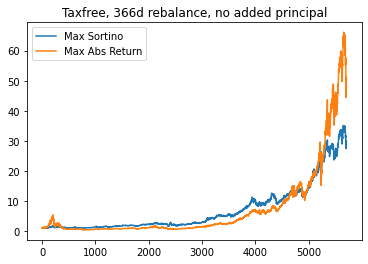

In [ ]:
plt.title("Taxfree, 366d rebalance, no added principal")

plt.plot(running_sum_portfolio_taxfree_nodca_366drebal)
plt.plot(sum_taxf_ndca_366d)
plt.legend(["Max Sortino", "Max Abs Return"])


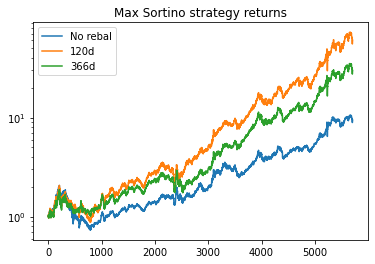

In [ ]:
plt.title("Max Sortino strategy returns")
plt.plot(running_sum_portfolio_taxfree_nodca_norebal)
plt.plot(running_sum_portfolio_taxfree_nodca_120drebal)
plt.plot(running_sum_portfolio_taxfree_nodca_366drebal)
plt.legend(["No rebal", "120d", "366d"])
plt.yscale("log")

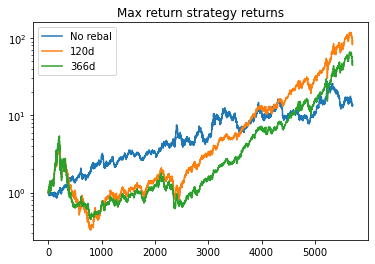

In [ ]:
plt.title("Max return strategy returns")

plt.plot(sum_taxf_ndca_nreb)
plt.plot(sum_taxf_ndca_120d)
plt.plot(sum_taxf_ndca_366d)
plt.legend(["No rebal", "120d", "366d"])
plt.yscale("log")

In [ ]:
#SECTION 2 - TAX FREE, FIXED ADDITIONAL PRINCIPAL ACCOUNT

In [ ]:
#we now handle the situation where you add a fixed amount of initial principal. 

In [ ]:
#title. taxfree portfolio simulator for a strategy (piediv) and our data
@jit(nopython=True)
def run_portfolio_taxfree_fixedadd(piediv, rebalancefreq, spydat, qqqdat, bonddat):

  #paydays assuming you add a % of initial principal each payday
  paydays = [30, 58, 89, 119, 150, 180, 211, 242, 272, 303, 333, 364]

  #initialization stuff...
  starting_principal = 1
  month_contrib = starting_principal/10

  running_value = np.zeros((len(spydat)+1, 18))
  running_sum = np.zeros((len(spydat)+1))
  running_sum[0] = starting_principal
  for i in range(len(piediv)):
    running_value[0, i] = starting_principal*piediv[i]
  #update
  for i in range(len(spydat)):
    running_value[i+1,:] = update_assets(running_value[i,:], spydat, qqqdat, bonddat, i)
    running_sum[i+1] = np.sum(running_value[i+1,:])
  
    if(i%rebalancefreq == 0 and i > 0):
      running_value[i+1] = rebalance(running_value[i+1], piediv)
    
    imod = i%365
    for k in range(len(paydays)):
      if(imod - paydays[k] == 0):
        for j in range(len(piediv)):
          running_value[i+1, j]+= month_contrib*piediv[j]
  
  return running_value, running_sum

In [ ]:
#get return of just bonds
def get_risk_free_fixedadd(spydat, qqqdat, bonddat):
  allbond = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
  vals, sums = run_portfolio_taxfree_fixedadd(allbond, 10000000000, spydat.to_numpy(), qqqdat.to_numpy(), bonddat.to_numpy())
  return sums[-1]

In [ ]:
risk_free_return = get_risk_free_fixedadd(spydat, qqqdat, bonddat)

/usr/local/lib/python3.7/dist-packages/numba/core/ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'piediv' of function 'run_portfolio_taxfree_fixedadd'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-67-f0a401fe0845>", line 3:
@jit(nopython=True)
def run_portfolio_taxfree_fixedadd(piediv, rebalancefreq, spydat, qqqdat, bonddat):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


In [ ]:
risk_free_return

42.71589067736243

In [ ]:
#tax free, additional principal, no rebalancing
max_sortino = 0
max_ind = -1
max_profit = 0
max_pind = -1
for i in range(len(pies)):
  running_value, running_sum = run_portfolio_taxfree_fixedadd(pies[i], 10000000000, spydat.to_numpy(), qqqdat.to_numpy(), bonddat.to_numpy())
  sortino = calc_sortino(running_sum, risk_free_return)
  if(sortino > max_sortino):
    max_sortino = sortino
    max_ind = i
  if(running_sum[-1] > max_profit):
    max_profit = running_sum[-1]
    max_pind = i
print(max_sortino)
printpie(pies[max_ind])
print(max_profit)
printpie(pies[max_pind])

7.074114549765126
0.4 2xqqq
0.4 1xbond
0.2 3xbond
1182.9940748167562
1.0 3xqqq


In [ ]:

running_value_portfolio_taxfree_fixedadd_norebal, running_sum_portfolio_taxfree_fixedadd_norebal = run_portfolio_taxfree_fixedadd(pies[max_ind], 10000000000, spydat.to_numpy(), qqqdat.to_numpy(), bonddat.to_numpy())
value_taxf_fixedadd_nreb, sum_taxf_fixedadd_nreb = run_portfolio_taxfree_fixedadd(pies[max_pind], 10000000000, spydat.to_numpy(), qqqdat.to_numpy(), bonddat.to_numpy())



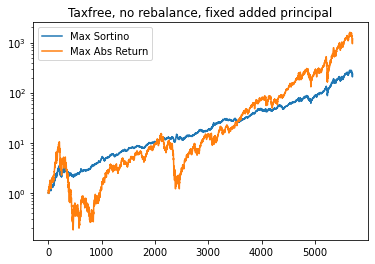

In [ ]:
plt.title("Taxfree, no rebalance, fixed added principal")

plt.plot(running_sum_portfolio_taxfree_fixedadd_norebal)
plt.plot(sum_taxf_fixedadd_nreb)
plt.yscale("log")
plt.legend(["Max Sortino", "Max Abs Return"])


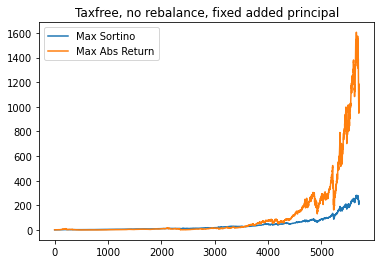

In [ ]:
plt.title("Taxfree, no rebalance, fixed added principal")

plt.plot(running_sum_portfolio_taxfree_fixedadd_norebal)
plt.plot(sum_taxf_fixedadd_nreb)
plt.legend(["Max Sortino", "Max Abs Return"])


In [ ]:
#tax free, additional principal, 120d rebalancing
max_sortino = 0
max_ind = -1
max_profit = 0
max_pind = -1
for i in range(len(pies)):
  running_value, running_sum = run_portfolio_taxfree_fixedadd(pies[i], 120, spydat.to_numpy(), qqqdat.to_numpy(), bonddat.to_numpy())
  sortino = calc_sortino(running_sum, risk_free_return)
  if(sortino > max_sortino):
    max_sortino = sortino
    max_ind = i
  if(running_sum[-1] > max_profit):
    max_profit = running_sum[-1]
    max_pind = i
print(max_sortino)
printpie(pies[max_ind])
print(max_profit)
printpie(pies[max_pind])

9.04918926712193
0.2 3xqqq
0.2 3xspy
0.6 3xbond
1291.9868876183705
0.8 3xqqq
0.2 3xbond


In [ ]:
running_value_portfolio_taxfree_fixedadd_120d, running_sum_portfolio_taxfree_fixedadd_120d = run_portfolio_taxfree_fixedadd(pies[max_ind], 120, spydat.to_numpy(), qqqdat.to_numpy(), bonddat.to_numpy())
value_taxf_fixedadd_120d, sum_taxf_fixedadd_120d = run_portfolio_taxfree_fixedadd(pies[max_pind], 120, spydat.to_numpy(), qqqdat.to_numpy(), bonddat.to_numpy())



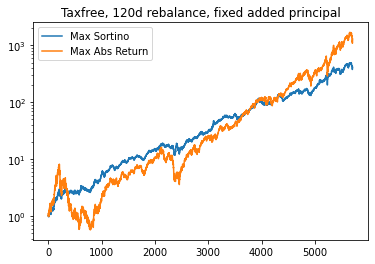

In [ ]:
plt.title("Taxfree, 120d rebalance, fixed added principal")

plt.plot(running_sum_portfolio_taxfree_fixedadd_120d)
plt.plot(sum_taxf_fixedadd_120d)
plt.yscale("log")
plt.legend(["Max Sortino", "Max Abs Return"])


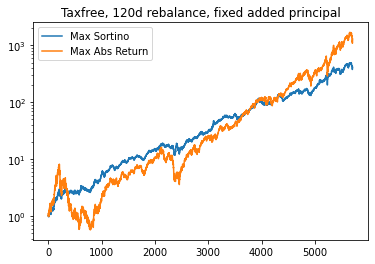

In [ ]:
plt.title("Taxfree, 120d rebalance, fixed added principal")

plt.plot(running_sum_portfolio_taxfree_fixedadd_120d)
plt.plot(sum_taxf_fixedadd_120d)
plt.yscale("log")
plt.legend(["Max Sortino", "Max Abs Return"])

In [ ]:
#tax free, additional principal, 366d rebalancing
max_sortino = 0
max_ind = -1
max_profit = 0
max_pind = -1
for i in range(len(pies)):
  running_value, running_sum = run_portfolio_taxfree_fixedadd(pies[i], 366, spydat.to_numpy(), qqqdat.to_numpy(), bonddat.to_numpy())
  sortino = calc_sortino(running_sum, risk_free_return)
  if(sortino > max_sortino):
    max_sortino = sortino
    max_ind = i
  if(running_sum[-1] > max_profit):
    max_profit = running_sum[-1]
    max_pind = i
print(max_sortino)
printpie(pies[max_ind])
print(max_profit)
printpie(pies[max_pind])

7.6508382875224035
0.4 1xqqq
0.2 3xspy
0.4 3xbond
1182.9940748167562
1.0 3xqqq


In [ ]:
running_value_portfolio_taxfree_fixedadd_120d, running_sum_portfolio_taxfree_fixedadd_366d = run_portfolio_taxfree_fixedadd(pies[max_ind], 366, spydat.to_numpy(), qqqdat.to_numpy(), bonddat.to_numpy())
value_taxf_fixedadd_366d, sum_taxf_fixedadd_366d = run_portfolio_taxfree_fixedadd(pies[max_pind], 366, spydat.to_numpy(), qqqdat.to_numpy(), bonddat.to_numpy())



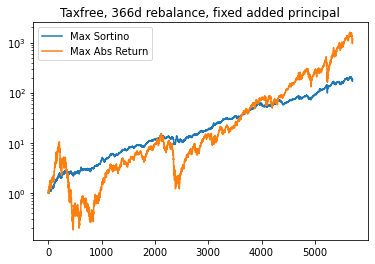

In [ ]:
plt.title("Taxfree, 366d rebalance, fixed added principal")

plt.plot(running_sum_portfolio_taxfree_fixedadd_366d)
plt.plot(sum_taxf_fixedadd_366d)
plt.yscale("log")
plt.legend(["Max Sortino", "Max Abs Return"])

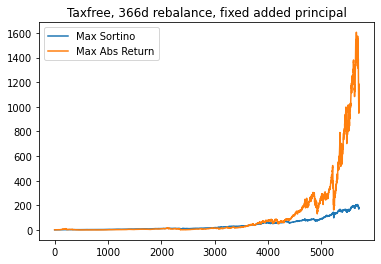

In [ ]:
plt.title("Taxfree, 366d rebalance, fixed added principal")

plt.plot(running_sum_portfolio_taxfree_fixedadd_366d)
plt.plot(sum_taxf_fixedadd_366d)

plt.legend(["Max Sortino", "Max Abs Return"])

In [ ]:
running_sum_portfolio_taxfree_fixedadd_366d[-1],sum_taxf_fixedadd_366d[-1]

(182.2657828675235, 1182.9940748167562)

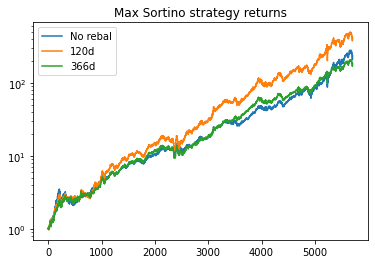

In [ ]:
plt.title("Max Sortino strategy returns")
plt.plot(running_sum_portfolio_taxfree_fixedadd_norebal)
plt.plot(running_sum_portfolio_taxfree_fixedadd_120d)
plt.plot(running_sum_portfolio_taxfree_fixedadd_366d)

plt.legend(["No rebal", "120d", "366d"])
plt.yscale("log")

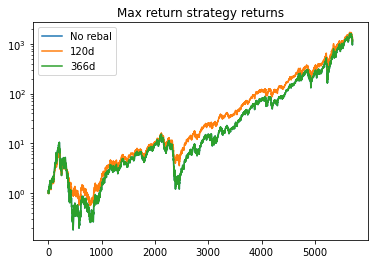

In [ ]:
plt.title("Max return strategy returns")


plt.plot(sum_taxf_fixedadd_nreb)
plt.plot(sum_taxf_fixedadd_120d)
plt.plot(sum_taxf_fixedadd_366d)

plt.legend(["No rebal", "120d", "366d"])
plt.yscale("log")

In [ ]:
#SECTION 3 - TAXED, GROWING ADDITIONAL PRINCIPAL ACCOUNT, SOFT REBALANCE

In [ ]:
#TAXABLE ACCOUNT - including income and income growth throughout 23yr period

In [ ]:
tc = 250000
tc_percent_growth = 1.075
savefrac = 0.3
#note - savefrac here DOES NOT INCLUDE what you are saving to pay taxes

In [ ]:
#total compensation growth defining function
@jit(nopython=True)
def tc_growth(tc_current, percent_growth):
  if(tc_current < 1000000):
    tc_current *= percent_growth
  return tc_current

In [ ]:
#calculates taxable gains according to 2022 rates, assume single status
@jit(nopython=True)
def calculate_taxes(short_capital, long_capital, income, deferred_loss):

  #calculate short term income
  taxes_owed = 0

  short_total = short_capital+income

  if(short_total+long_capital > 0):

    #calculate short term gains tax
    if(215950 <= short_total <= 539900):
      taxes_owed += short_total*0.35
    else:
      taxes_owed += short_total*0.37

    #calculate long term gains tax
    if(short_total <= 459750):
      taxes_owed += long_capital*0.15
    else:
      taxes_owed += long_capital*0.2
  else:
    deferred_loss += (short_total+long_capital)*-1

  #calculate deferred loss
  if(deferred_loss > taxes_owed):
    deferred_loss -= taxes_owed
    taxes_owed = 0
  else:
    taxes_owed -= deferred_loss
    deferred_loss = 0
  
  return taxes_owed, deferred_loss

In [ ]:
#quick calculator for how to rebalance portfolio given our desired allocation
@jit(nopython=True)
def rebalance_soft(shmoney, alloc, cashtoadd):
  cash = 0

  for i in range(len(shmoney)):
    cash+=shmoney[i]

  for i in range(len(alloc)):
    if(shmoney[i] < alloc[i]*cash):
      addon = np.min(np.array([cashtoadd, alloc[i]*cash - shmoney[i]]))
      cashtoadd -= addon
      shmoney[i] += addon

  if(cashtoadd > 0):
    for i in range(len(alloc)):
      shmoney[i] += alloc[i]*cashtoadd
  return shmoney

In [ ]:
#assume initial investment = tc*savefrac (1yr savings)
@jit(nopython=True)
def run_portfolio_softrebalance(piediv, rebalancefreq, spydat, qqqdat, bonddat, tc, tc_percent_growth, savefrac):

  #paydays assuming you add a % of yearly savings each month
  paydays = [30, 58, 89, 119, 150, 180, 211, 242, 272, 303, 333, 364]

  short_gains = 0
  long_gains = 0
  deferred_losses = 0
  taxes_owed = 0

  #initialization stuff...
  starting_principal = tc*savefrac
  month_contrib = tc*savefrac/12

  prev_account_val = starting_principal

  running_value = np.zeros((len(spydat)+1, 18))
  running_sum = np.zeros((len(spydat)+1))
  running_sum[0] = starting_principal

  for i in range(len(piediv)):
    running_value[0, i] = starting_principal*piediv[i]

  #update
  for i in range(len(spydat)):
    running_value[i+1,:] = update_assets(running_value[i,:], spydat, qqqdat, bonddat, i)
    
    running_sum[i+1] = np.sum(running_value[i+1,:])
    
    imod = i%365
    for k in range(len(paydays)):
      if(imod - paydays[k] == 0):
          running_value[i+1, :] = rebalance_soft(running_value[i+1, :], piediv, month_contrib)
          running_sum[i+1] = np.sum(running_value[i+1,:])

    if(imod == 0 and i > 0):
      tc = tc_growth(tc, tc_percent_growth)
      month_contrib = tc*savefrac/12

  return running_value, running_sum

In [ ]:
#get return of just bonds
def get_risk_free_softrebal(spydat, qqqdat, bonddat):
  allbond = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
  vals, sums = run_portfolio_softrebalance(allbond, 10000000000, spydat.to_numpy(), qqqdat.to_numpy(), bonddat.to_numpy(), 250000, 1.075, 0.3)
  return sums[-1]

In [ ]:
risk_free_return = get_risk_free_softrebal(spydat, qqqdat, bonddat)

/usr/local/lib/python3.7/dist-packages/numba/core/ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'piediv' of function 'run_portfolio_softrebalance'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-102-3a7a703db70c>", line 3:
@jit(nopython=True)
def run_portfolio_softrebalance(piediv, rebalancefreq, spydat, qqqdat, bonddat, tc, tc_percent_growth, savefrac):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


In [ ]:
#tax free, additional principal, 366d rebalancing
max_sortino = 0
max_ind = -1
max_profit = 0
max_pind = -1
for i in range(len(pies)):
  running_value, running_sum = run_portfolio_softrebalance(pies[i], 30, spydat.to_numpy(), qqqdat.to_numpy(), bonddat.to_numpy(), 250000, 1.075, 0.3)
  sortino = calc_sortino(running_sum, risk_free_return)
  if(sortino > max_sortino):
    max_sortino = sortino
    max_ind = i
  if(running_sum[-1] > max_profit):
    max_profit = running_sum[-1]
    max_pind = i
print(max_sortino)
printpie(pies[max_ind])
print(max_profit)
printpie(pies[max_pind])

13.432030984006133
0.4 2xqqq
0.6 3xbond
109479810.19102485
1.0 3xqqq


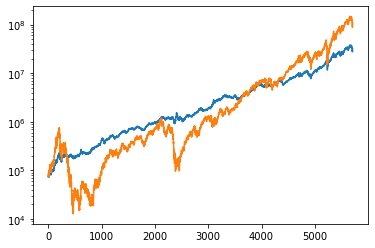

In [ ]:
running_value_portfolio_softrebal, running_sum_portfolio_softrebal = run_portfolio_softrebalance(pies[max_ind], 366, spydat.to_numpy(), qqqdat.to_numpy(), bonddat.to_numpy(), 250000, 1.075, 0.3)
value_taxed_softrebal_366d, sum_taxed_softrebal_366d = run_portfolio_softrebalance(pies[max_pind], 366, spydat.to_numpy(), qqqdat.to_numpy(), bonddat.to_numpy(), 250000, 1.075, 0.3)
plt.plot(running_sum_portfolio_softrebal)
plt.plot(sum_taxed_softrebal_366d)
plt.yscale("log")

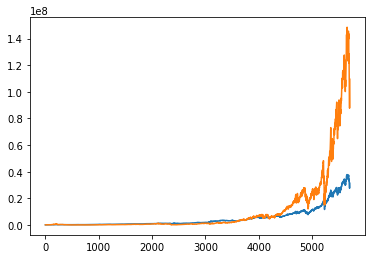

In [ ]:
plt.plot(running_sum_portfolio_softrebal)
plt.plot(sum_taxed_softrebal_366d)
#plt.yscale("log")

In [ ]:
running_sum_portfolio_softrebal[-1]/sum_taxed_softrebal_366d[-1]

0.28622769282945854

In [ ]:
#simulation - long term market conditions
#bond, spy, qqq 5yr moving average
numdays = 365*5
bondmove, spymove, qqqmove = bonddat['PERCENT_DIV'].rolling(numdays).mean()[numdays:], spydat['PERCENT_DIV'].rolling(numdays).mean()[numdays:], qqqdat['PERCENT_DIV'].rolling(numdays).mean()[numdays:]

In [ ]:
len(bondmove), len(spymove), len(qqqmove), len(bonddat)

(3883, 3883, 3883, 5708)

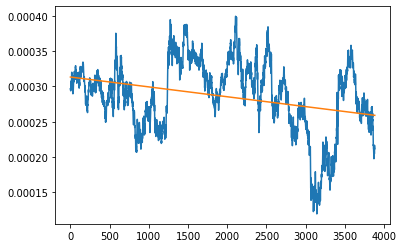

In [ ]:
bondtrend = np.polyfit(range(len(bondmove)), bondmove, 1)
bondline = np.poly1d(bondtrend)
plt.plot(bondmove.values)
plt.plot(bondline(range(len(bondmove))).reshape(len(bondmove)))
#bondline(range(len(bondmove))).shape, len(bondmove)

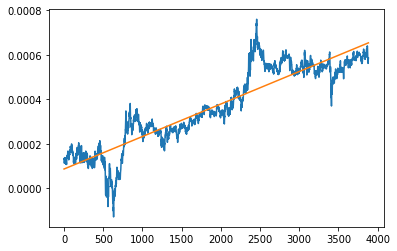

In [ ]:
spytrend = np.polyfit(range(len(spymove)), spymove, 1)
spyline = np.poly1d(spytrend)
plt.plot(spymove.values)
plt.plot(spyline(range(len(spymove))).reshape(len(spymove)))

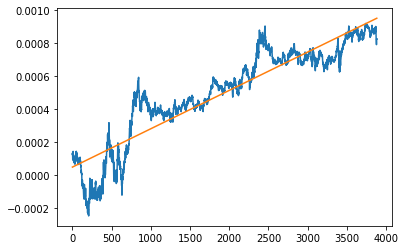

In [ ]:
qqqtrend = np.polyfit(range(len(qqqmove)), qqqmove, 1)
qqqline = np.poly1d(qqqtrend)
plt.plot(qqqmove.values)
plt.plot(qqqline(range(len(qqqmove))).reshape(len(qqqmove)))